In [11]:
import pandas as pd
import numpy as np
import json

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt


In [12]:
risk_dict = {
    # (70-90%)
    "high": {
        "V11": [
            {"range": (4.45, 5.29), "fraud_rate": 78.69, "count": 61},
        ],
        "V12": [
            {"range": (-14.70, -13.38), "fraud_rate": 76.67, "count": 30},
            {"range": (-9.40, -8.07), "fraud_rate": 88.10, "count": 42},
            {"range": (-8.07, -6.74), "fraud_rate": 76.27, "count": 59},
            {"range": (-6.74, -5.42), "fraud_rate": 88.24, "count": 68},
        ],
        "V14": [
            {"range": (-14.75, -13.27), "fraud_rate": 90.00, "count": 30},
            {"range": (-13.27, -11.78), "fraud_rate": 80.00, "count": 30},
            {"range": (-11.78, -10.29), "fraud_rate": 79.55, "count": 44},
            {"range": (-10.29, -8.80), "fraud_rate": 76.67, "count": 60},
        ],
        "V17": [
            {"range": (-14.84, -13.12), "fraud_rate": 76.47, "count": 34},
            {"range": (-11.40, -9.68), "fraud_rate": 85.71, "count": 28},
            {"range": (-7.95, -6.23), "fraud_rate": 86.67, "count": 45},
            {"range": (-6.23, -4.51), "fraud_rate": 76.83, "count": 82},
        ]
    },
    # (10-70%)
    "mid": {
        "V4": [
            {"range": (5.60, 6.72), "fraud_rate": 28.63, "count": 241},
            {"range": (6.72, 7.85), "fraud_rate": 44.87, "count": 78},
            {"range": (7.85, 8.98), "fraud_rate": 56.86, "count": 51},
        ],
        "V10": [
            {"range": (-10.09, -7.67), "fraud_rate": 65.00, "count": 60},
            {"range": (-7.67, -5.25), "fraud_rate": 66.67, "count": 117},
            {"range": (-5.25, -2.84), "fraud_rate": 23.01, "count": 665},
        ],
        "V11": [
            {"range": (2.77, 3.61), "fraud_rate": 10.59, "count": 680},
            {"range": (3.61, 4.45), "fraud_rate": 59.17, "count": 120},
        ],
        "V12": [
            {"range": (-5.42, -4.09), "fraud_rate": 34.12, "count": 170},
        ],
        "V14": [
            {"range": (-8.80, -7.32), "fraud_rate": 65.71, "count": 105},
            {"range": (-7.32, -5.83), "fraud_rate": 54.96, "count": 131},
            {"range": (-5.83, -4.34), "fraud_rate": 24.67, "count": 300},
        ],
        "V17": [
            {"range": (-4.51, -2.79), "fraud_rate": 58.24, "count": 91},
            {"range": (5.81, 7.53), "fraud_rate": 13.46, "count": 52},
        ]
    },
    # (1-10%)
    "low": {
        "V4": [
            {"range": (3.34, 4.47), "fraud_rate": 1.25, "count": 6024},
            {"range": (4.47, 5.60), "fraud_rate": 3.79, "count": 1477},
        ],
        "V11": [
            {"range": (1.93, 2.77), "fraud_rate": 1.12, "count": 5179},
            {"range": (2.77, 3.61), "fraud_rate": 10.59, "count": 680},
        ],
        "V12": [
            {"range": (-4.09, -2.76), "fraud_rate": 1.60, "count": 4436},
        ],
        "V14": [
            {"range": (-4.34, -2.86), "fraud_rate": 2.29, "count": 1965},
        ],
        "V17": [
            {"range": (4.09, 5.81), "fraud_rate": 2.80, "count": 214},
        ]
    }
}

# TOTAL : 19945 transactions, 1425 frauds (7.5%)

# (high/mid/low) 19k = ~ 7% total dataset & 7.5% fraud 
# (high/mid) 3.4k = ~ 1,2% total dataset & 40% fraud 
# (high) 613 = ~ 0,2% total dataset & 81% fraud 

In [13]:
def amount_risk_flag(amount):
    return 1 if 100 <= amount <= 1000 else 0

def compute_risk_features(row, risk_dict):
    score = 0
    risk_counts = {"low": 0, "mid": 0, "high": 0}

    for level, features in risk_dict.items():
        level_score = {"low": 1, "mid": 2, "high": 3}[level]
        for feature, bins in features.items():
            value = row.get(feature, None)
            if value is None:
                continue
            for b in bins:
                low, high = b["range"]
                if low <= value < high:
                    score += level_score
                    risk_counts[level] += 1
                    break

    return pd.Series({
        "risk_score": score,
        "risk_low": risk_counts["low"],
        "risk_mid": risk_counts["mid"],
        "risk_high": risk_counts["high"]
    })

def build_features(df, risk_dict):
    df = df.copy()
    df['amount_high_fraud_zone'] = df['Amount'].apply(amount_risk_flag)
    risk_features = df.apply(compute_risk_features, axis=1, risk_dict=risk_dict)
    return pd.concat([df, risk_features], axis=1)


In [14]:
# Load dataset
df = pd.read_csv("../data/creditcard.csv")

# Build features
df = build_features(df, risk_dict)

In [15]:
features = [
    'V4', 'V10', 'V11', 'V12', 'V14', 'V17',
    'Amount', 'risk_score', 'risk_low', 'risk_mid', 'risk_high', 'amount_high_fraud_zone'
]
X = df[features]
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [16]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.74      0.84       148

    accuracy                           1.00     85443
   macro avg       0.98      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC: 0.9279409854194425


In [17]:
thresholds = np.arange(0.1, 1.0, 0.1)

print("Threshold | Precision | Recall | F1")
print("-" * 40)
for threshold in thresholds:
    y_thresh = (y_proba > threshold).astype(int)
    p = precision_score(y_test, y_thresh, zero_division=0)
    r = recall_score(y_test, y_thresh)
    f1 = f1_score(y_test, y_thresh)
    print(f"{threshold:8.2f} | {p:9.2f} | {r:6.2f} | {f1:4.2f}")


Threshold | Precision | Recall | F1
----------------------------------------
    0.10 |      0.75 |   0.83 | 0.79
    0.20 |      0.86 |   0.82 | 0.84
    0.30 |      0.91 |   0.80 | 0.85
    0.40 |      0.95 |   0.78 | 0.86
    0.50 |      0.96 |   0.74 | 0.84
    0.60 |      0.97 |   0.69 | 0.81
    0.70 |      0.98 |   0.65 | 0.78
    0.80 |      0.98 |   0.56 | 0.71
    0.90 |      0.97 |   0.43 | 0.59


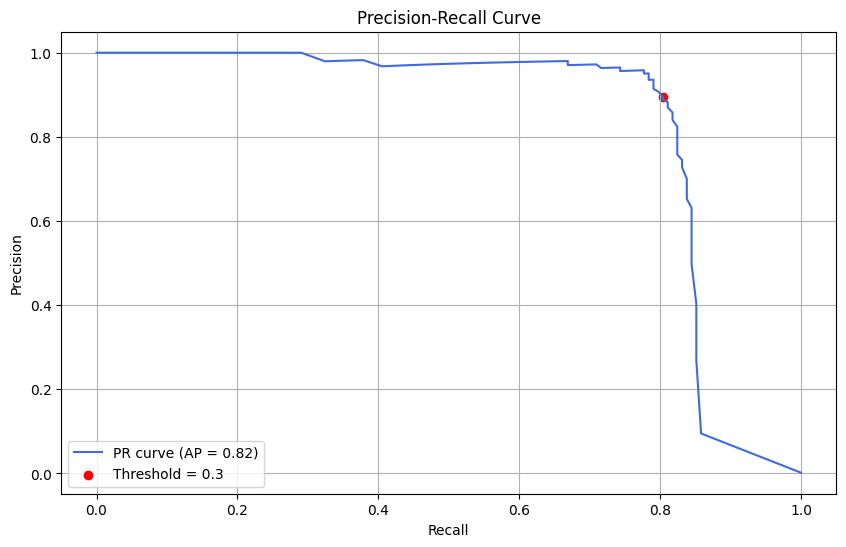

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

threshold = 0.3
idx = np.argmin(np.abs(thresholds - threshold))

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.2f})', color='royalblue')
plt.scatter(recall[idx], precision[idx], color='red', label=f'Threshold = {threshold}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()
